In [1]:
import glob
import os
import json
from datetime import timedelta
import dask.bag
from dask.distributed import Client
from kerchunk.netCDF3 import NetCDF3ToZarr
from kerchunk.combine import MultiZarrToZarr
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np
import xarray as xr
xr.set_options(keep_attrs=True)
%matplotlib inline

In [2]:
# CAM output files
FILES = {
    'control': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.01/atm/hist/*.h0.*.nc"))
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.control.06/atm/hist/*.h0.*.nc")),
    'SAI2020': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.01/atm/hist/*.h0.*.nc"))[0:300] # 2020-2044
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02/atm/hist/*.h0.*.nc"))[:-12] # 2045-2099
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02_ext02/atm/hist/*.h0.*.nc")), # 2100-2130
    'SAI2080': sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.feedback.09/atm/hist/*.h0.*.nc"))
        + sorted(glob.glob("/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01/atm/hist/*.h0.*.nc"))
}

# CAM stratospheric forcing files
STFILES = {
    'SAI20': '/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02/strataero/ozone_strataero_WACCM_L70_zm5day_2015-2100_SSP585_CAMfeedback-2100.nc',
    'SAI20E': '/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2020feedback.02_ext02/strataero/ozone_strataero_WACCM_L70_zm5day_2015-2150_SSP585_CAMfeedback-2131.nc',
    'SAI2080': '/projects/0/uuesm2/archive/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01/strataero/ozone_strataero_WACCM_L70_zm5day_2015-2150_SSP585_CAMfeedback.nc',
}


# WACCM output files
WACFILES = {
    'control': ['/home/jasperdj/simone/CMIP6/so4/mmrso4_AERmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
        '/home/jasperdj/simone/CMIP6/o3/o3_Amon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc',
        '/home/jasperdj/simone/CMIP6/aod/od550so4_AERmon_CESM2-WACCM_ssp585_r1i1p1f1_gn_201501-210012.nc'],
    'SAI2020': ['/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.AODVISstdn.201901-206812.nc',
        '/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0.AODVISstdn.206901-210012.nc']
        + sorted(glob.glob('/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0zm.so4_a?.*.nc')) 
        + sorted(glob.glob('/home/jasperdj/simone/GLENS/b.e21.BWSSP585cmip6.f09_g17.CMIP6-SSP5-8.5-WACCM.feedback.15C.001.cam.h0zm.O3.*.nc'))
}

In [3]:
def open_mfdataset(filepaths: list[str], ncstore_dir: str='~/kerchunk', **kwargs):
    """a faster alternative to xr.open_mfdataset using kerchunk
    
    This function uses kerchunk to create an NC_STORE reference file,
    that instructs the program how to read the netCDF files efficiently. 
    Coordinates must be consistent throughout all files.
    The NC_STORE is saved after first use, and will be read on each 
    subsequent usage of this function.
    
    Parameters:
    filepaths : str or list[str]
        (list of) netCDF file names, may contain wild cards
    ncstore_dir: Pathlike
        Path where NC_STORE reference files will be saved
    kwargs: dict
        any additional keyword arguments are passed on to xr.open_dataset
        
    Returns: xr.Dataset
        a Dataset instance containing all the netCDF data
        
    v0.0
    """
    
    # make sorted list of absolute filepaths
    if isinstance(filepaths, str):
        filepaths = glob.glob(filepaths)
    filepaths = sorted([os.path.abspath(fp) for fp in filepaths])
    if len(filepaths) == 1: # use xr.open_dataset directly if there is one file
        return xr.open_dataset(filepaths[0], **kwargs)
    
    # set default keyword arguments for xr.open_dataset on NC_STORE file
    default_kw = {'engine':'kerchunk', 'storage_options':{'target_protocol':'file'}}
    for (k,v) in default_kw.items():
        if k in kwargs:
            print(f'open_mfdataset(): ignoring keyword {k}')
        kwargs[k] = v
    
    # create NC_STORE filename from netCDF filename, including timestamp
    # of first and last file. Open and return dataset if the file already exists
    ncstore_dir = os.path.expanduser(ncstore_dir)
    timestr = lambda i: os.path.basename(filepaths[i]).split('.')[-2] # timestamp
    ncstorefile = (os.path.basename(filepaths[0])
                   .replace(timestr(0),f"{timestr(0)}_{timestr(-1)}")
                   .replace('.nc','.json'))
    ncstore_path = os.path.join(ncstore_dir, ncstorefile)
    if not os.path.exists(ncstore_dir):
        os.mkdir(ncstore_dir)
    elif os.path.exists(ncstore_path):
        print(f"Reading combined kerchunk reference file {ncstore_path}")
        return xr.open_dataset(ncstore_path, **kwargs)
    
    # make new NC_STORE data
    filebag = dask.bag.from_sequence(filepaths, npartitions=None)
    reffiles = (filebag.map(NetCDF3ToZarr, inline_threshold=0, max_chunk_size=0)
                .map(lambda z: z.translate()).compute())
    mzz = MultiZarrToZarr(reffiles, concat_dims=['time'], coo_map={'time':'cf:time'})
    
    # write NC_STORE data and return opened dataset
    with open(f"{ncstore_path}", "wb") as f:
       print(f"Writing combined kerchunk reference file {ncstore_path}")
       f.write(json.dumps(mzz.translate()).encode())
    
    return xr.open_dataset(ncstore_path, **kwargs)

In [4]:
# open CAM output files
cam = {k:open_mfdataset(v, chunks={'time':1}) for k,v in FILES.items()}
for exp in cam:
    cam[exp] = cam[exp].assign_coords({'time':('time',(cam[exp].time-timedelta(days=15,hours=12)).data,cam[exp].time.attrs)})

Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.control.01.cam.h0.2015-01_2130-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.2020feedback.01.cam.h0.2020-01_2130-12.json
Reading combined kerchunk reference file /home/jasperdj/kerchunk/b.e21.BSSP585cmip6.f09_g17.2080feedback_ext01.cam.h0.2100-01_2099-12.json


In [5]:
# open CAM strataero forcing files
cam_strat = {k: xr.open_dataset(STFILES[k]).sel(time=slice('2015','2130')) for k in STFILES}
cam_strat['SAI2020'] = xr.concat((cam_strat['SAI20'].sel(time=slice('2015','2101-01-01')), 
                                  cam_strat['SAI20E'].sel(time=slice('2101-01-02','2130'))), dim='time')
del cam_strat['SAI20']
del cam_strat['SAI20E']

In [6]:
# open WACCM output files
waccm = {
    'control': xr.open_mfdataset(WACFILES['control'], compat='override'),
    'SAI2020': xr.open_mfdataset(WACFILES['SAI2020'], preprocess=lambda ds:ds.set_coords('lon')),
}
waccm['SAI2020'] = waccm['SAI2020'].assign_coords({'time':('time',waccm['SAI2020'].time_bnds.mean('nbnd').data, waccm['SAI2020'].time.attrs)})

/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'mmrso4' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'o3' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)
/home/jasperdj/miniconda3/envs/geo/lib/python3.12/site-packages/xarray/conventions.py:286: SerializationWarning: variable 'od550so4' has multiple fill values {1e+20, 1e+20} defined, decoding all values to NaN.
  var = coder.decode(var, name=name)


In [7]:
%%time
# compute annual mean global mean AOD and zonal mean SO4 conc.

AODzm = {
    'cam': {
        'control': cam['control'].AODVISstdn.mean('lon').coarsen(time=12).mean(), # monthly data
        'SAI2020': cam_strat['SAI2020'].AODVISstdn.coarsen(time=73).mean(), # there are 73 data points each year
        'SAI2080': cam_strat['SAI2080'].AODVISstdn.coarsen(time=73).mean(),
    },
    'waccm': {
        'control': waccm['control'].od550so4.mean('lon').coarsen(time=12).mean(),
        'SAI2020': waccm['SAI2020'].AODVISstdn.mean('lon').coarsen(time=12).mean(),
    },
}

SO4 = {
    'cam': {
        'SAI2020': cam_strat['SAI2020'].so4mass_a1+cam_strat['SAI2020'].so4mass_a2+cam_strat['SAI2020'].so4mass_a3,
    },
    'waccm': {
        'SAI2020': waccm['SAI2020'].so4_a1+waccm['SAI2020'].so4_a2+waccm['SAI2020'].so4_a3,
    }
}

gw = cam['control'].gw.isel(time=0)
AODgm = AODzm.copy()
for mod in AODzm:
    for exp,da in AODzm[mod].items():
        AODgm[mod][exp] = (da.weighted(gw).mean('lat').compute() if (da is not None) else None)

SO4tm = SO4.copy()
for mod in SO4:
    for exp,da in SO4[mod].items():
        SO4tm[mod][exp] = da.sel(time=slice('2070','2100')).mean('time')

CPU times: user 6.28 s, sys: 5.38 s, total: 11.7 s
Wall time: 13.3 s


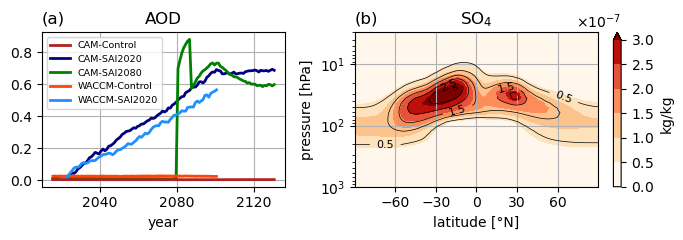

In [11]:
fig, ax = plt.subplots(1,2, figsize=(7,2.5), width_ratios=[1,1.25])

# line plot
AODgm['cam']['control'].plot(ax=ax[0], c='firebrick', lw=2, label='CAM-Control', zorder=4)
AODgm['cam']['SAI2020'].plot(ax=ax[0], c='navy', lw=2, label='CAM-SAI2020')
AODgm['cam']['SAI2080'].plot(ax=ax[0], c='green', lw=2, label='CAM-SAI2080')
AODgm['waccm']['control'].plot(ax=ax[0], c='orangered', lw=2, label='WACCM-Control')
AODgm['waccm']['SAI2020'].plot(ax=ax[0], c='dodgerblue', lw=2, label='WACCM-SAI2020')

# contour

#so4mass = so4mass.sel(time=slice('2070','2100')).mean('time')
p2a = SO4tm['cam']['SAI2020'].isel(lev=slice(25,70)).plot.contourf(ax=ax[1], yscale='log', cmap='OrRd', vmin=0, levels=np.arange(0,3.1e-7,0.5e-7))
p2b = SO4tm['waccm']['SAI2020'].isel(lev=slice(25,70)).plot.contour(ax=ax[1], yscale='log', colors='k', linewidths=0.5, vmin=0, levels=np.arange(0,3.1e-7,0.5e-7))
ax[1].invert_yaxis() # needs to be called before clabel
plt.clabel(p2b, levels=p2b.levels[1::2], inline=True, fontsize=8)
ax[0].legend(loc='upper left', prop={'size':6.9})
ax[0].set_xlabel('year')
ax[0].set_ylabel('')
ax[0].set_title(r'AOD'); ax[0].set_title('(a)', loc='left')
ax[0].grid()
ax[1].set_ylim([1000,3])
ax[1].set_ylabel('pressure [hPa]')
ax[1].set_xlabel('latitude [°N]')
ax[1].set_xticks(range(-60,61,30))
ax[1].grid()
ax[1].set_title(r'SO$_4$'); ax[1].set_title('(b)', loc='left')

cbax = p2a.colorbar.ax
cbax.set_ylabel(f"{cam_strat['SAI2020'].so4mass_a3.units}")
cbax.ticklabel_format(useMathText=True)

plt.tight_layout()
fig.savefig('figures/aod_so4mass.pdf')

In [9]:
%%time
O3gm = {
    'cam': {
        'control': cam['control'].sel(time=slice('2015','2130')).O3.mean('lon').max(('lev','lat')).coarsen(time=12).mean().compute(),
        'SAI2020': cam['SAI2020'].sel(time=slice('2102','2130')).O3.mean('lon').max(('lev','lat')).coarsen(time=12).mean().compute(),
        'SAI2080': cam['SAI2080'].sel(time=slice('2080','2130')).O3.mean('lon').max(('lev','lat')).coarsen(time=12).mean().compute(),
    },
    'waccm': {
        'control': waccm['control'].o3.sel(time=slice('2020','2100')).mean('lon').max(('plev','lat')).coarsen(time=12).mean().compute(),
        'SAI2020': waccm['SAI2020'].O3.sel(time=slice('2020','2100')).max(('lev','lat')).coarsen(time=12).mean().compute(),
    },
}

CPU times: user 1min 1s, sys: 12.3 s, total: 1min 14s
Wall time: 46.6 s


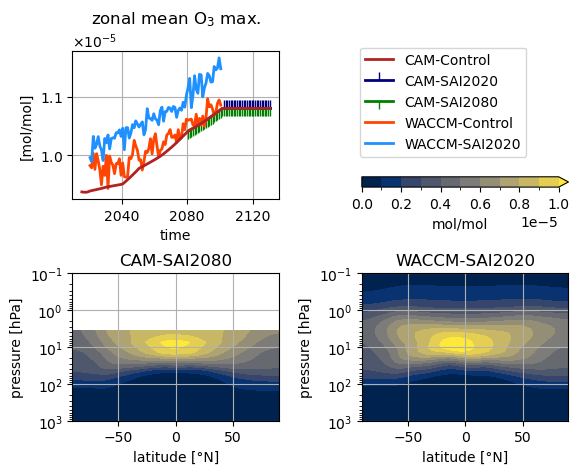

In [12]:
fig, axs = plt.subplots(2,2)
Olevels = np.linspace(0,1e-5,11)
for ax in axs.flatten():
    ax.grid(which='major')
    
# CAM
O3gm['cam']['control'].plot(ax=axs[0,0], lw=2, label='CAM-Control', c='firebrick', zorder=4, markersize=4)
O3gm['cam']['SAI2020'].plot(ax=axs[0,0], lw=2, label='CAM-SAI2020', c='navy', linestyle='-', marker=2)
O3gm['cam']['SAI2080'].plot(ax=axs[0,0], lw=2, label='CAM-SAI2080', c='green',linestyle='-', marker=3)

# WACCM
O3gm['waccm']['control'].plot(ax=axs[0,0], lw=2, label='WACCM-Control', c='orangered')
O3gm['waccm']['SAI2020'].plot(ax=axs[0,0], lw=2, label='WACCM-SAI2020', c='dodgerblue')


# zonal mean O3
cam['SAI2080'].sel(time=slice('2080','2100')).O3.mean(('time','lon')).plot.contourf(ax=axs[1,0], yincrease=False, yscale='log', ylim=[1000,0.1], levels=Olevels, add_colorbar=False, cmap='cividis')
p = waccm['SAI2020'].O3.sel(time=slice('2080','2100')).mean(('time')).plot.contourf(ax=axs[1,1], yscale='log', yincrease=False, levels=Olevels, ylim=[1000,0.1], add_colorbar=False, cmap='cividis')

axs[0,0].set_title('zonal mean O$_3$ max.')
axs[1,0].set_title('CAM-SAI2080')
axs[1,1].set_title('WACCM-SAI2020')
axs[1,0].set_xlabel('latitude [°N]')
axs[1,1].set_xlabel('latitude [°N]')
axs[0,0].set_ylabel('[mol/mol]')
axs[1,0].set_ylabel('pressure [hPa]')
axs[1,1].set_ylabel('pressure [hPa]')
axs[0,0].ticklabel_format(axis='y', useMathText=True)

cb = fig.colorbar(p, ax=axs[0,1], orientation='horizontal')
cb.ax.set_xlabel('mol/mol')
fig.delaxes(axs[0,1])
plt.subplots_adjust(wspace=0.4, hspace=0.5)
axs[0,0].legend(prop={'size':10}, bbox_to_anchor=(2.23,1.07))
fig.savefig('figures/ozone.pdf')